在本练习中，您将实现正则化的线性回归，并使用它来研究具有不同偏差-方差属性的模型

## 1 Regularized Linear Regression 正则线性回归

在前半部分的练习中，你将实现正则化线性回归，以预测水库中的水位变化，从而预测大坝流出的水量。在下半部分中，您将通过一些调试学习算法的诊断，并检查偏差 v.s. 方差的影响。

### 1.1 Visualizing the dataset

我们将从可视化数据集开始，其中包含水位变化的历史记录，x，以及从大坝流出的水量，y。

这个数据集分为了三个部分：
- training set 训练集：训练模型
- cross validation set 交叉验证集：选择正则化参数
- test set 测试集：评估性能，模型训练中不曾用过的样本

In [90]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt

读取数据

In [91]:
path = 'ex5data1.mat'
data = loadmat(path)
#Training set
X, y = data['X'], data['y']
#Cross validation set
Xval, yval = data['Xval'], data['yval']
#Test set
Xtest, ytest = data['Xtest'], data['ytest']
#Insert a column of 1's to all of the X's, as usual
X = np.insert(X    ,0,1,axis=1)
Xval = np.insert(Xval ,0,1,axis=1)
Xtest = np.insert(Xtest,0,1,axis=1)
print('X={},y={}'.format(X.shape, y.shape))
print('Xval={},yval={}'.format(Xval.shape, yval.shape))
print('Xtest={},ytest={}'.format(Xtest.shape, ytest.shape))

X=(12, 2),y=(12, 1)
Xval=(21, 2),yval=(21, 1)
Xtest=(21, 2),ytest=(21, 1)


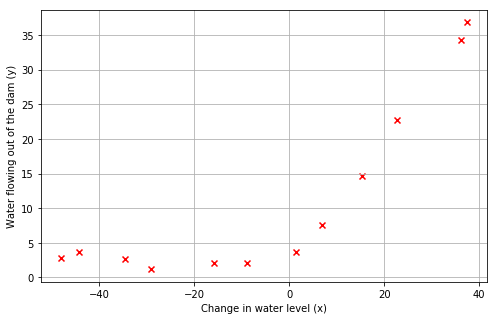

In [177]:
def plotData():
    """瞧一瞧数据长啥样"""
    plt.figure(figsize=(8,5))
    plt.scatter(X[:,1:], y, c='r', marker='x')
    plt.xlabel('Change in water level (x)')
    plt.ylabel('Water flowing out of the dam (y)')
    plt.grid(True)
    
plotData()

### 1.2 Regularized linear regression cost function

![image.png](https://upload-images.jianshu.io/upload_images/11023262-33264b2e9f116780.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [165]:
def costReg(theta, X, y, l):
    '''do not regularizethe theta0
    theta is a 1-d array with shape (n+1,)
    X is a matrix with shape (m, n+1)
    y is a matrix with shape (m, 1)
    '''
    cost = ((X @ theta - y.flatten()) ** 2).sum()
    regterm = l * (theta[1:] @ theta[1:])
    return (cost + regterm) / (2 * len(X))

 Using theta initialized at [1, 1], and lambda = 1, you should expect to see an output of 303.993192

In [94]:
theta = np.ones(X.shape[1])
print(costReg(theta, X, y, 1))

303.9931922202643


### 1.3 Regularized linear regression gradient

![image.png](https://upload-images.jianshu.io/upload_images/11023262-a1535bcc657c400a.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

In [95]:
def gradientReg(theta, X, y, l):
    """
    theta: 1-d array with shape (2,)
    X: 2-d array with shape (12, 2)
    y: 2-d array with shape (12, 1)
    l: lambda constant
    grad has same shape as theta (2,)
    """
    grad = (X @ theta - y.flatten()) @ X
    regterm = l * theta
    regterm[0] = 0  # #don't regulate bias term
    return (grad + regterm) / len(X)

# Using theta initialized at [1; 1] you should expect to see a 
# gradient of [-15.303016; 598.250744] (with lambda=1)
print(gradientReg(theta, X, y, 1))

[-15.30301567 598.25074417]


### 1.4 Fitting linear regression 拟合线性回归

In [96]:
def trainLinearReg(X, y, l):
    theta = np.zeros(X.shape[1])
    res = opt.minimize(fun=costReg, 
                       x0=theta, 
                       args=(X, y ,l), 
                       method='TNC', 
                       jac=gradientReg)
    return res.x

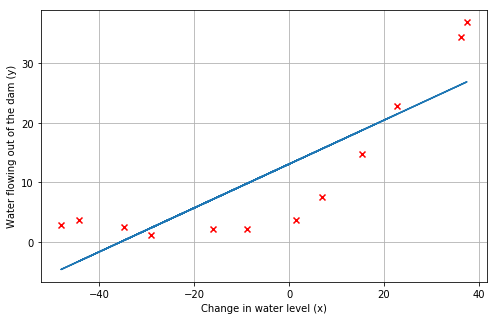

In [97]:
fit_theta = trainLinearReg(X, y, 0)
plotData()
plt.plot(X[:,1], X @ fit_theta)

这里我们把$\lambda$ = 0，因为我们现在实现的线性回归只有两个参数，这么低的维度，正则化并没有用。

从图中可以看到，拟合最好的这条直线告诉我们这个模型并不适合这个数据。

在下一节中，您将实现一个函数来生成学习曲线，它可以帮助您调试学习算法，即使可视化数据不那么容易。

## 2 Bias-variance

机器学习中一个重要的概念是偏差（bias）和方差（variance）的权衡。高偏差意味着欠拟合，高方差意味着过拟合。

在这部分练习中，您将在学习曲线上绘制训练误差和验证误差，以诊断bias-variance问题。

### 2.1 Learning curves 学习曲线

![image.png](https://upload-images.jianshu.io/upload_images/11023262-c532ba2077cca7c6.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

训练样本X从1开始逐渐增加，训练出不同的参数向量θ。接着通过交叉验证样本Xval计算验证误差。

1. 使用训练集的子集来训练模型，得到不同的theta。

2. 通过theta计算训练代价和交叉验证代价，切记此时**不要使用正则化**，将 $\lambda = 0$。

3. 计算交叉验证代价时记得整个交叉验证集来计算，无需分为子集。

In [124]:
def plot_learning_curve(X, y, Xval, yval, l):
    """画出学习曲线，即交叉验证误差和训练误差随样本数量的变化的变化"""
    xx = range(1, len(X) + 1)  # at least has one example 
    training_cost, cv_cost = [], []
    for i in xx:
        res = trainLinearReg(X[:i], y[:i], l)
        training_cost_i = costReg(res, X[:i], y[:i], 0)
        cv_cost_i = costReg(res, Xval, yval, 0)
        training_cost.append(training_cost_i)
        cv_cost.append(cv_cost_i)
        
    plt.figure(figsize=(8,5))
    plt.plot(xx, training_cost, label='training cost')  
    plt.plot(xx, cv_cost, label='cv cost') 
    plt.legend()
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.title('Learning curve for linear regression')
    plt.grid(True)

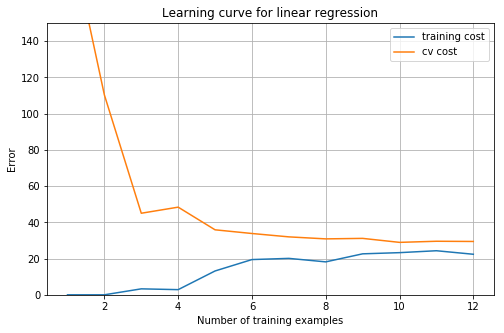

In [125]:
learningCurve(X, y, Xval, yval, 0)

从图中看出来，随着样本数量的增加，训练误差和交叉验证误差都很高，这属于高偏差，欠拟合。

## 3 Polynomial regression 多项式回归

我们的线性模型对于数据来说太简单了，导致了欠拟合(高偏差)。在这一部分的练习中，您将通过添加更多的特性来解决这个问题。

使用多项式回归，假设函数形式如下：
![image.png](https://upload-images.jianshu.io/upload_images/11023262-0048932987bbaf06.png?imageMogr2/auto-orient/strip%7CimageView2/2/w/1240)

### 3.1 Learning Polynomial Regression 

数据预处理

1. X，Xval，Xtest都需要添加多项式特征，这里我们选择增加到6次方，因为若选8次方无法达到作业pdf上的效果图，这是因为scipy和octave版本的优化算法不同。

2. 不要忘了标准化。

In [181]:
def genPolyFeatures(X, power):
    """添加多项式特征
    每次在array的最后一列插入第二列的i+2次方（第一列为偏置）
    从二次方开始开始插入（因为本身含有一列一次方）
    """
    Xpoly = X.copy()
    for i in range(2, power + 1):
        Xpoly = np.insert(Xpoly, Xpoly.shape[1], np.power(Xpoly[:,1], i), axis=1)
    return Xpoly

def get_means_std(X):
    """获取训练集的均值和误差，用来标准化所有数据。"""
    means = np.mean(X,axis=0)
    stds = np.std(X,axis=0,ddof=1)  # ddof=1 means 样本标准差
    return means, stds

def featureNormalize(myX, means, stds):
    """标准化"""
    X_norm = myX.copy()
    X_norm[:,1:] = X_norm[:,1:] - means[1:]
    X_norm[:,1:] = X_norm[:,1:] / stds[1:]
    return X_norm


关于归一化，所有数据集应该都用**训练集的均值和样本标准差**处理。切记。所以要将训练集的均值和样本标准差存储起来，对后面的数据进行处理。

而且注意这里是**样本标准差而不是总体标准差**，使用np.std()时，将ddof=1则是样本标准差，默认=0是总体标准差。而pandas默认计算样本标准差。




获取添加多项式特征以及 标准化之后的数据。

In [184]:
power = 6  # 扩展到x的6次方

train_means, train_stds = get_means_std(genPolyFeatures(X,power))
X_norm = featureNormalize(genPolyFeatures(X,power), train_means, train_stds)
Xval_norm = featureNormalize(genPolyFeatures(Xval,power), train_means, train_stds)
Xtest_norm = featureNormalize(genPolyFeatures(Xtest,power), train_means, train_stds)

In [191]:
def plot_fit(means, stds, l):
    theta = trainLinearReg(X_norm,y, l)
    x = np.linspace(-75,55,50)
    xmat = x.reshape(-1, 1)
    xmat = np.insert(xmat,0,1,axis=1)
    Xmat = genPolyFeatures(xmat, power)
    Xmat_norm = featureNormalize(Xmat, means, stds)
    
    plotData()
    plt.plot(x, Xmat_norm@theta,'b--')

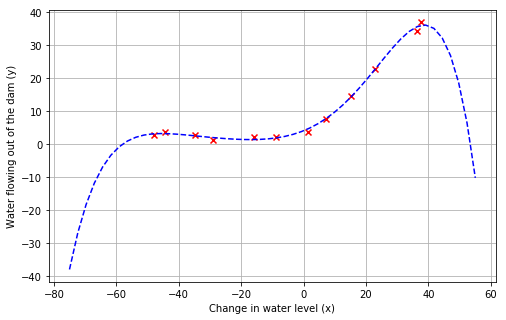

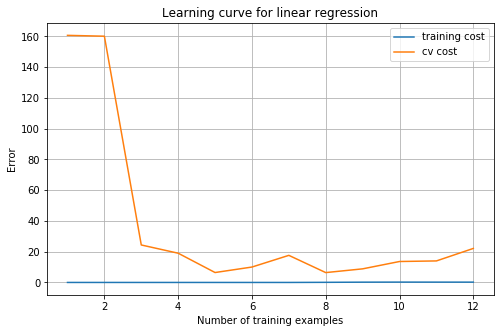

In [192]:
plot_fit(train_means, train_stds, 0)
plot_learning_curve(X_norm, y, Xval_norm, yval, 0)

### 3.2 Adjusting the regularization parameter

上图可以看到 $\lambda$ = 0时，训练误差太小了，明显过拟合了。

我们继续调整$\lambda$ = 1 时：

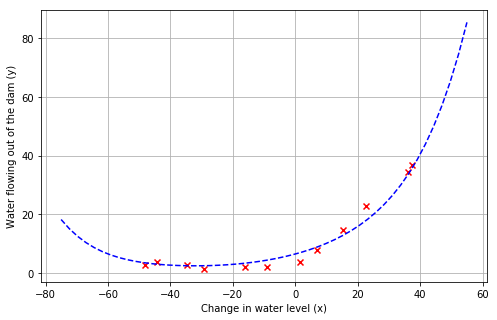

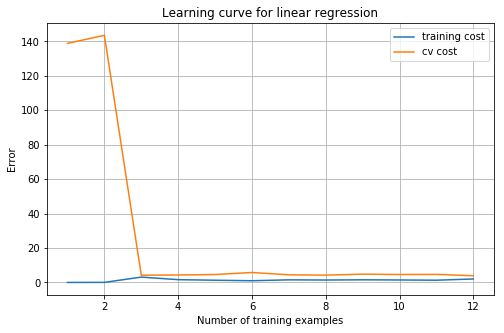

In [193]:
plot_fit(train_means, train_stds, 1)
plot_learning_curve(X_norm, y, Xval_norm, yval, 1)

我们继续调整$\lambda$ = 100 时，很明显惩罚过多，欠拟合了

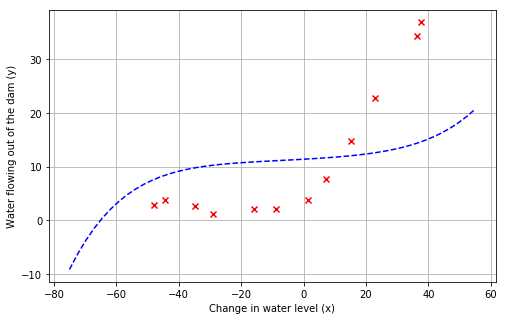

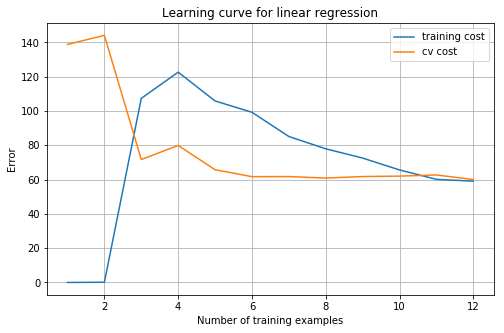

In [194]:
plot_fit(train_means, train_stds, 100)
plot_learning_curve(X_norm, y, Xval_norm, yval, 100)

### 3.3 Selecting λ using a cross validation set

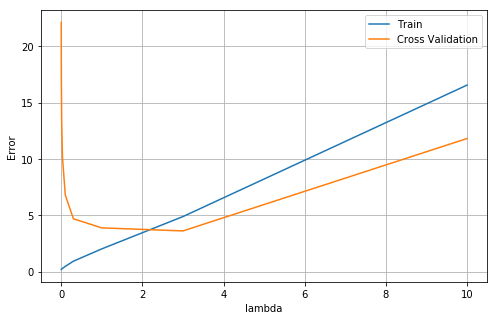

In [199]:
lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
# lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for l in lambdas:
    theta = trainLinearReg(X_norm, y, l)
    errors_train.append(costReg(theta,X_norm,y,0))  # 记得把lambda = 0
    errors_val.append(costReg(theta,Xval_norm,yval,0))
    
plt.figure(figsize=(8,5))
plt.plot(lambdas,errors_train,label='Train')
plt.plot(lambdas,errors_val,label='Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)

In [201]:
# 可以看到时交叉验证代价最小的是 lambda = 3
lambdas[np.argmin(errors_val)]

3.0

### 3.4 Computing test set error

In our cross validation, we obtained a test error of 3.8599 for λ = 3.

实际上我在上面调整了power=6来匹配作业里面的图，所以得不到3.8599。但是调整power=8时（同作业里一样）,就可以得到上述数据。

In [203]:
theta = trainLinearReg(X_norm, y, 3)
print('test cost(l={}) = {}'.format(3, costReg(theta, Xtest_norm, ytest, 0)))
# for l in lambdas:
#     theta = trainLinearReg(X_norm, y, l)
#     print('test cost(l={}) = {}'.format(l, costReg(theta, Xtest_norm, ytest, 0)))

test cost(l=3) = 4.755272039159912
